# <font color='#badc58'> Fake News Detector with LSTM |<br> </font>  
# <font color='#3dc1d3'>  
1.  Preprocess data
2.  one_hot encoding
3.  create LSTM model
4.  observe the alteration in shape, flattening and then re-shaping - changes from embedding to flattening - to - dense layer <br>
5. Observe the total weight matrix size of the LSTM - mathematical verification

## <font color='#f9ca24'> LSTM 
 <font color='00BFEB'>'fit' or train on some training data; joins these two steps and is used for the initial fitting of parameters on the training set 𝑥, while also returning the transformed 𝑥′. Internally, the transformer object just calls first fit() and then transform() on the same data.<br>In the output, you will see (20000, 5) which means that each of the document has 5 columns where each column corresponds to the probability value of a particular topic. 

In [1]:
import re
import pandas as pd
import nltk
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout 
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.metrics import classification_report 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
from google.colab import files
upload = files.upload()

Saving fakenews.zip to fakenews.zip


In [3]:
!unzip fakenews

Archive:  fakenews.zip
  inflating: train.csv               


In [4]:
df = pd.read_csv("train.csv")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### <font color='#badc58'>Let's take a look at the dataset.</font>  <br/> 
---


In [5]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [6]:
df['label'][100]

1

In [7]:
df.shape

(20800, 5)

In [8]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

<font color='#badc58'>drop missing data</font>  <br/> 

In [9]:
df = df.dropna(subset=['title','text'])
df.isnull().sum()

id           0
title        0
author    1918
text         0
label        0
dtype: int64

<font color='#badc58'>Preparing to create the model


In [10]:
x = df.drop(columns='label')
y = df['label']

In [11]:
x.shape, y.shape  #array dimensions 

((20203, 4), (20203,))

<font color='#7ed6df'>Data Preprocessing

In [12]:
#create shallow copy - create a new object
copy = x.copy()
#copies the reference of nested objects
copy.reset_index(inplace=True)

In [13]:
ws = WordNetLemmatizer()
list_titles = []
for i in range(0, len(copy)):
  #print(i)#print copy['title' - i]
  headline = re.sub('[^a-zA-Z]', ' ', copy['title'][i])
  #matching the text string for any lower case letter or uppercase 
  #when the ^ is on the inside of [], itmatches any character that does not appear inside []
  #when ^ is on the outside of the []; i tmatches the beginning of the line/string - title 
  headline = headline.lower()
  headline = headline.split()
  headline = [ws.lemmatize(word) for word in headline if word not in stopwords.words("english")]
  headline = ' '.join(headline)
  list_titles.append(headline) #adds a single item to the existing list

In [14]:
list_titles[:4]

['house dem aide even see comey letter jason chaffetz tweeted',
 'flynn hillary clinton big woman campus breitbart',
 'truth might get fired',
 'civilian killed single u airstrike identified']

In [17]:
#for i in range(0, len(messages)):
    #print('\n', messages['title'][i])

<font color='#f9ca24'>Keras<font color='#7ed6df'> provide the function <font color='#f9ca24'>one_hot</font> to efficiently encode each word in the titles as an interger.<br>This must be done prior to Word Embedding<br><font color='#7ed6df'>Index of words located in the Dictionary

In [18]:
vocab = 10000
hot_title = [one_hot(i, vocab) for i in list_titles]
hot_title[:4]

[[9903, 8280, 7471, 8385, 7615, 7910, 6327, 5775, 8334, 5578],
 [5814, 4160, 6416, 6681, 4439, 8282, 7238],
 [4811, 3239, 3513, 4948],
 [3534, 4742, 3373, 5902, 2586, 5442]]

<font color='#7ed6df'>Longest sentence<br>

In [19]:
longest = len(max(list_titles, key = len))
longest

356

<font color='#7ed6df'>Making every sentence of the data of Same Length<br> <font color='#f9ca24'>pad_sequences </font>is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence

In [20]:
max_length = 356
embed_input = pad_sequences(hot_title, maxlen = max_length, padding='pre')
print(embed_input)

[[   0    0    0 ... 5775 8334 5578]
 [   0    0    0 ... 4439 8282 7238]
 [   0    0    0 ... 3239 3513 4948]
 ...
 [   0    0    0 ... 7790 7312 7078]
 [   0    0    0 ... 2238 5221 1240]
 [   0    0    0 ... 1868 6419 7600]]


<font color='#7ed6df'>Arguments: <br>
<font color='#f9ca24'>sequences </font>	
List of lists where each element is a sequence<br>
<font color='#f9ca24'>maxlen </font>		
int, maximum length of all sequences

<font color='#f9ca24'>dtype </font>	<font color='#7ed6df'>	
type of the output sequences

<font color='#f9ca24'>padding </font><font color='#7ed6df'>
'pre' or 'post', pad either before or after each sequence.



<font color='#7ed6df'>Input shape<br>2D tensor with shape: (batch_size, input_length).

<font color='#f9ca24'>Creating the Model

In [21]:
model = Sequential() #creating the sequential model incrementally vi the add() method
model.add(Embedding(input_dim=vocab, output_dim= 40, input_length=356))
model.add(LSTM(150))
model.add(Dense(1, activation='sigmoid'))#sigmoid returns a value close to zero
#config the model with losses and metrics - compile()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 356, 40)           400000    
                                                                 
 lstm (LSTM)                 (None, 150)               114600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 514,751
Trainable params: 514,751
Non-trainable params: 0
_________________________________________________________________
None


<font color='#7ed6df'>sequence()a plain stack of layers where each layer has exactly one input tensor and one output tensor<br>create a Sequential model incrementally via the add() method<br>the input of the LSTM is always a 3D array
(batch_size, time_steps, units)<br>
The output of the LSTM could be a 2D array or 3D array depending upon the return_sequences argument.
If return_sequence is False, the output is a 2D array. (batch_size, units)
If return_sequence is True, the output is a 3D array. (batch_size, time_steps, units)<br> in this case; the return_sequence is false - this is the default, therefore - 2D LSTM output

3D tensor with shape: (batch_size, input_length, output_dim).
alteration in shape, flattening and then re-shaping


<font color='#f9ca24'>Describe model

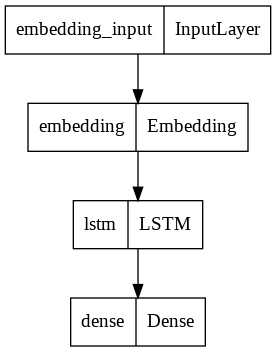

In [22]:
plot_model(model)

In [23]:
len(embed_input),y.shape

(20203, (20203,))

In [24]:
x_final = np.array(embed_input)
y_final = np.array(y)
x_final.shape, y_final.shape 

((20203, 356), (20203,))

In [25]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.33, random_state=42)

<font color='#7ed6df'>fitting the model

In [26]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64) 

Epoch 1/10
212/212 [==============================] - 24s 87ms/step - loss: 0.4379 - accuracy: 0.7860 - val_loss: 0.2261 - val_accuracy: 0.9091
Epoch 2/10
212/212 [==============================] - 18s 85ms/step - loss: 0.1528 - accuracy: 0.9393 - val_loss: 0.1907 - val_accuracy: 0.9205
Epoch 3/10
212/212 [==============================] - 17s 82ms/step - loss: 0.0796 - accuracy: 0.9715 - val_loss: 0.2072 - val_accuracy: 0.9253
Epoch 4/10
212/212 [==============================] - 17s 82ms/step - loss: 0.0373 - accuracy: 0.9894 - val_loss: 0.2465 - val_accuracy: 0.9253
Epoch 5/10
212/212 [==============================] - 17s 82ms/step - loss: 0.0158 - accuracy: 0.9959 - val_loss: 0.2990 - val_accuracy: 0.9265
Epoch 6/10
212/212 [==============================] - 17s 82ms/step - loss: 0.0118 - accuracy: 0.9976 - val_loss: 0.2695 - val_accuracy: 0.9184
Epoch 7/10
212/212 [==============================] - 18s 84ms/step - loss: 0.0064 - accuracy: 0.9993 - val_loss: 0.3846 - val_accuracy: